Czytanie plików fio i dd

In [3]:
import os
import re
from collections import defaultdict
import glob
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


In [34]:
def parse_fio_results(file_path):
    # Regular expressions
    bandwidth_regex = re.compile(r'WRITE: bw=(\d+(?:\.\d+)?)([MK]iB/s)')
    bandwidth_read_regex = re.compile(r'READ: bw=(\d+(?:\.\d+)?)([MK]iB/s)')
    iops_regex = re.compile(r'write: IOPS=(\d+)')
    iops_read_regex = re.compile(r'read: IOPS=(\d+)')
    latency_regex = re.compile(r'lat (\([mu]sec\)): min=\d+\.?\d*[km]?, max=\d+\.?\d*[km]?, avg=(\d+\.\d+[km]?), stdev=\d+\.?\d*')

    # Function to convert bandwidth to MiB/s
    def convert_bandwidth(value, unit):
        value = float(value)
        if unit == "KiB/s":
            return value / 1024  # Convert KiB/s to MiB/s
        return value  # Already in MiB/s

    results = {}

    with open(file_path, 'r') as file:
        last = 'read'
        for line in file:
            # Match write bandwidth
            if 'write' in line:
                last = 'write'
            elif 'read' in line:
                last = 'read'
            bw_match = bandwidth_regex.search(line)
            if bw_match:
                value, unit = bw_match.groups()
                results['Bandwidth WRITE (MiB/s)'] = convert_bandwidth(value, unit)

            # Match read bandwidth
            bw_read_match = bandwidth_read_regex.search(line)
            if bw_read_match:
                value, unit = bw_read_match.groups()
                results['Bandwidth READ (MiB/s)'] = convert_bandwidth(value, unit)

            # Match write IOPS
            iops_match = iops_regex.search(line)
            if iops_match:
                results['IOPS WRITE'] = float(iops_match.group(1))

            # Match read IOPS
            iops_read_match = iops_read_regex.search(line)
            if iops_read_match:
                results['IOPS READ'] = float(iops_read_match.group(1))

            # Match latency
            lat_match = latency_regex.search(line)
            if lat_match:
                lat_val = float(lat_match.group(2))
                if lat_match.group(1) == '(usec)':
                    lat_val /= 1000
                if last == 'read':
                    results['Latency READ (ms)'] = lat_val
                else:
                    results['Latency WRITE (ms)'] = lat_val

    return results

def parse_dd_results(file_path):
    # Regular expressions
    bandwidth_regex = re.compile(r'(\d+(?:\.\d+)?) ([GMK]B/s)')
    time_regex = re.compile(r'(\d+(?:\.\d+)?) s')

    # Function to convert bandwidth to MiB/s
    def convert_bandwidth(value, unit):
        value = float(value)
        if unit == "KB/s":
            return value / 1024  # Convert KB/s to MiB/s
        elif unit == "MB/s":
            return value  # Already in MiB/s
        elif unit == "GB/s":
            return value * 1024  # Convert GB/s to MiB/s
        return value

    results = {}

    with open(file_path, 'r') as file:
        for line in file:
            # Match bandwidth
            bw_match = bandwidth_regex.search(line)
            if bw_match:
                value, unit = bw_match.groups()
                if 'write' in file_path:
                    results['Bandwidth WRITE (MiB/s)'] = convert_bandwidth(value, unit)
                else:
                    results['Bandwidth READ (MiB/s)'] = convert_bandwidth(value, unit)

            # Match time
            time_match = time_regex.search(line)
            if time_match:
                results['Time (s)'] = float(time_match.group(1))

    return results

def extract_values(resultsfolder, file_names, parser, program_type):
    resultsdict = {'ext4': {}, 'xfs': {}, 'btrfs': {}, 'zfs': {}, 'f2fs': {}}
    cumulative_data = {file_name.split('_')[1]: defaultdict(list) for file_name in file_names}
    prepaths = [folder for folder in glob.glob(resultsfolder + '*/') if program_type in folder]  # Filter by program type
    for prepath in prepaths:
        filesystem = prepath.split('\\')[-2].split('_')[2]
        storage = prepath.split('\\')[-2].split('_')[3]
        folders = [folder for folder in glob.glob(prepath + '*/')]
        cumulative_data = {file_name.split('_')[1]: defaultdict(list) for file_name in file_names}
        for folder in folders:
            for file_name in file_names:
                file_path = os.path.join(folder, file_name)
                if os.path.exists(file_path):
                    try:
                        results = parser(file_path)
                        for key, value in results.items():
                            cumulative_data[file_name.split('_')[1]][key].append(value)
                    except Exception as e:
                        print(f"Error parsing {file_path}: {e}")
                else:
                    print(f"File not found: {file_path}")

        ranges = {}
        for file_name, metrics in cumulative_data.items():
            ranges[file_name] = {
                key: {'min': round(min(values), 3), 'max': round(max(values), 3), 'avg': round(sum(values) / len(values), 2)} if values else '-'
                for key, values in metrics.items()
            }
        resultsdict[filesystem][storage] = ranges
    return resultsdict


def parse_hdparm_results(file_path):
    # Regular expression to match the bandwidth
    bandwidth_regex = re.compile(r'Timing O_DIRECT disk reads: (\d+(?:\.\d+)?) MB in .* seconds = (\d+(?:\.\d+)) MB/sec')

    results = {}

    with open(file_path, 'r') as file:
        for line in file:
            # Match bandwidth
            bw_match = bandwidth_regex.search(line)
            if bw_match:
                total_mb, bandwidth = bw_match.groups()
                results['Total Data Read (MB)'] = float(total_mb)
                results['Bandwidth (MiB/s)'] = float(bandwidth)

    return results

In [46]:

# Example usage for fio
fio_file_names = [
    'fio_database_test_output.txt',
    'fio_multimedia_test_output.txt',
    'fio_webserver_test_output.txt',
    'fio_archive_test_output.txt',
]

fio_resultsdict = extract_values('../wyniki_test4/', fio_file_names, parse_fio_results, program_type='fio_results')


# Example usage for dd
dd_file_names = [
    'dd_read_test_output.txt',
    'dd_write_test_output.txt',
]

dd_resultsdict = extract_values('../wyniki_test4/', dd_file_names, parse_dd_results, program_type='dd_results')

hdparm_file_names = [
    'hdparm_test_output.txt',
]

hdparm_resultsdict = extract_values('../wyniki_test4/', hdparm_file_names, parse_hdparm_results, program_type='hdparm_results')

print(hdparm_resultsdict)

{'ext4': {'hdd': {'test': {'Total Data Read (MB)': {'min': 466.0, 'max': 466.0, 'avg': 466.0}, 'Bandwidth (MiB/s)': {'min': 155.2, 'max': 155.2, 'avg': 155.2}}}}, 'xfs': {}, 'btrfs': {'hdd': {'test': {'Total Data Read (MB)': {'min': 480.0, 'max': 480.0, 'avg': 480.0}, 'Bandwidth (MiB/s)': {'min': 159.77, 'max': 159.77, 'avg': 159.77}}}}, 'zfs': {}, 'f2fs': {}}


Funkcja do generowania wykresów

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_performance_metrics(data, metrics, storage_types, include_min_max=False, workload=None, file_systems=None, colors=None):
    if colors is None:
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Default list of colors for different file systems
    
    if file_systems is None:
        file_systems = list(data.keys())  # Use all file systems if none are provided
    
    for storage in storage_types:
        valid_metrics = []
        for metric in metrics:
            for fs in file_systems:
                if fs in data and storage.lower() in data[fs]:
                    results = data[fs][storage.lower()]
                    if workload:
                        if workload in results and results[workload].get(metric, {}):
                            valid_metrics.append(metric)
                            break
                    else:
                        for operation, metrics_data in results.items():
                            if metric in metrics_data:
                                valid_metrics.append(metric)
                                break
        
        if not valid_metrics:
            continue  # Skip if there are no valid metrics for this storage type
        
        fig, axs = plt.subplots(len(valid_metrics), 1, figsize=(10, 3 * len(valid_metrics)))
        fig.suptitle(f'Performance Metrics for {storage}{" - " + workload.capitalize() if workload else ""}')
        
        for i, metric in enumerate(valid_metrics):
            fs_labels = []
            avg_values = []
            min_values = []
            max_values = []
            color_map = {}
            for idx, fs in enumerate(file_systems):
                if fs in data and storage.lower() in data[fs]:
                    results = data[fs][storage.lower()]
                    if workload:
                        if workload in results:
                            values = results[workload].get(metric, {})
                            if values:
                                fs_labels.append(fs)
                                avg_values.append(values['avg'])
                                if include_min_max:
                                    min_values.append(values.get('min', values['avg']))
                                    max_values.append(values.get('max', values['avg']))
                                color_map[fs] = colors[idx % len(colors)]  # Assign color to file system
                    else:
                        for operation, metrics_data in results.items():
                            if metric in metrics_data:
                                values = metrics_data[metric]
                                fs_labels.append(fs)
                                avg_values.append(values['avg'])
                                if include_min_max:
                                    min_values.append(values.get('min', values['avg']))
                                    max_values.append(values.get('max', values['avg']))
                                color_map[fs] = colors[idx % len(colors)]  # Assign color to file system
            
            bars = axs[i].bar(fs_labels, avg_values, color=[color_map[fs] for fs in fs_labels])
            if include_min_max:
                yerr = [np.array(avg_values) - np.array(min_values), np.array(max_values) - np.array(avg_values)]
                yerr = np.abs(yerr)  # Ensure yerr does not contain negative values
                axs[i].errorbar(fs_labels, avg_values, yerr=yerr, fmt='o', color='black')
            axs[i].set_title(metric)
            axs[i].set_ylabel(metric)
            # Create a custom legend without colors
            axs[i].legend([f'{storage} {metric}'], handletextpad=0, handlelength=0)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

Funkcja do generowania tabelki fio

In [47]:
# Function to generate all possible columns
def generate_columns(metrics, stats):
    storage_types = ["HDD", "SSD", "NVME"]
    columns = ["File System"]
    for storage in storage_types:
        for metric in metrics:
            for stat in stats:
                columns.append(f"{storage} {metric} {stat}")
    return columns


def extract_row_data(data, workload, columns):
    rows = []
    for fs, devices in data.items():
        row = [fs]
        for col in columns[1:]:  # Skip File System 
            if len(col.split()) > 3:
                col = col.split()
                storage, metric, stat = col[0],col[1]+' '+col[2],col[3]
            else:
                storage, metric, stat = col.split(" ", 2)
            if workload == 'database':
                if "Latency" in metric:
                    metric_key = f"{metric} (ms)"
                else:
                    metric_key = f"{metric} (MiB/s)" if "Bandwidth" in metric else metric
            elif workload == 'archive':
                if metric == "Latency":
                    metric_key = "Latency WRITE (ms)"
                else:
                    metric_key = f"{metric} WRITE (MiB/s)" if metric == "Bandwidth" else f"{metric} WRITE"
            else:
                if metric == "Latency":
                    metric_key = "Latency READ (ms)"
                else:
                    metric_key = f"{metric} READ (MiB/s)" if metric == "Bandwidth" else f"{metric} READ"
            # Extract value
            value = "N/A"
            for device_type, workloads in devices.items():
                if device_type.lower() == storage.lower() and workload in workloads:
                    value = workloads[workload].get(metric_key, {}).get(stat.lower(), "N/A")
                    break
            row.append(value)
        rows.append(row)
    return rows


workloads = ["database", "multimedia", "webserver", "archive"]
stats_to_display = ["MIN", "AVG", "MAX"]  # You can change this list to display different stats

# Generate and display tables for each workload
for workload in workloads:
    if workload == "database":
        columns = generate_columns(["Bandwidth READ","Bandwidth WRITE", "IOPS READ","IOPS WRITE","Latency READ", "Latency WRITE"], stats_to_display)
    else:
        columns = generate_columns(["Bandwidth", "IOPS", "Latency"], stats_to_display)
    rows = extract_row_data(fio_resultsdict, workload, columns)
    df = pd.DataFrame(rows, columns=columns)
    display(df.style.set_caption(f"Performance Metrics: {workload.capitalize()}").format(precision=3))

,File System,HDD Bandwidth READ MIN,HDD Bandwidth READ AVG,HDD Bandwidth READ MAX,HDD Bandwidth WRITE MIN,HDD Bandwidth WRITE AVG,HDD Bandwidth WRITE MAX,HDD IOPS READ MIN,HDD IOPS READ AVG,HDD IOPS READ MAX,HDD IOPS WRITE MIN,HDD IOPS WRITE AVG,HDD IOPS WRITE MAX,HDD Latency READ MIN,HDD Latency READ AVG,HDD Latency READ MAX,HDD Latency WRITE MIN,HDD Latency WRITE AVG,HDD Latency WRITE MAX,SSD Bandwidth READ MIN,SSD Bandwidth READ AVG,SSD Bandwidth READ MAX,SSD Bandwidth WRITE MIN,SSD Bandwidth WRITE AVG,SSD Bandwidth WRITE MAX,SSD IOPS READ MIN,SSD IOPS READ AVG,SSD IOPS READ MAX,SSD IOPS WRITE MIN,SSD IOPS WRITE AVG,SSD IOPS WRITE MAX,SSD Latency READ MIN,SSD Latency READ AVG,SSD Latency READ MAX,SSD Latency WRITE MIN,SSD Latency WRITE AVG,SSD Latency WRITE MAX,NVME Bandwidth READ MIN,NVME Bandwidth READ AVG,NVME Bandwidth READ MAX,NVME Bandwidth WRITE MIN,NVME Bandwidth WRITE AVG,NVME Bandwidth WRITE MAX,NVME IOPS READ MIN,NVME IOPS READ AVG,NVME IOPS READ MAX,NVME IOPS WRITE MIN,NVME IOPS WRITE AVG,NVME IOPS WRITE MAX,NVME Latency READ MIN,NVME Latency READ AVG,NVME Latency READ MAX,NVME Latency WRITE MIN,NVME Latency WRITE AVG,NVME Latency WRITE MAX
0,ext4,1.233,1.230,1.233,0.534,0.530,0.534,262.000,262.000,262.000,114.000,114.000,114.000,347.680,347.680,347.680,317.196,317.200,317.196,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,xfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
2,btrfs,1.842,1.840,1.842,0.802,0.800,0.802,393.000,393.000,393.000,171.000,171.000,171.000,256.800,256.800,256.800,155.970,155.970,155.970,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,zfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
4,f2fs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


,File System,HDD Bandwidth MIN,HDD Bandwidth AVG,HDD Bandwidth MAX,HDD IOPS MIN,HDD IOPS AVG,HDD IOPS MAX,HDD Latency MIN,HDD Latency AVG,HDD Latency MAX,SSD Bandwidth MIN,SSD Bandwidth AVG,SSD Bandwidth MAX,SSD IOPS MIN,SSD IOPS AVG,SSD IOPS MAX,SSD Latency MIN,SSD Latency AVG,SSD Latency MAX,NVME Bandwidth MIN,NVME Bandwidth AVG,NVME Bandwidth MAX,NVME IOPS MIN,NVME IOPS AVG,NVME IOPS MAX,NVME Latency MIN,NVME Latency AVG,NVME Latency MAX
0,ext4,138.000,138.000,138.000,1105.000,1105.000,1105.000,230.480,230.480,230.480,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,xfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
2,btrfs,143.000,143.000,143.000,1140.000,1140.000,1140.000,223.590,223.590,223.590,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,zfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
4,f2fs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


,File System,HDD Bandwidth MIN,HDD Bandwidth AVG,HDD Bandwidth MAX,HDD IOPS MIN,HDD IOPS AVG,HDD IOPS MAX,HDD Latency MIN,HDD Latency AVG,HDD Latency MAX,SSD Bandwidth MIN,SSD Bandwidth AVG,SSD Bandwidth MAX,SSD IOPS MIN,SSD IOPS AVG,SSD IOPS MAX,SSD Latency MIN,SSD Latency AVG,SSD Latency MAX,NVME Bandwidth MIN,NVME Bandwidth AVG,NVME Bandwidth MAX,NVME IOPS MIN,NVME IOPS AVG,NVME IOPS MAX,NVME Latency MIN,NVME Latency AVG,NVME Latency MAX
0,ext4,1.258,1.260,1.258,293.000,293.000,293.000,1733.880,1733.880,1733.880,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,xfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
2,btrfs,1.323,1.320,1.323,308.000,308.000,308.000,1650.730,1650.730,1650.730,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,zfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
4,f2fs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


,File System,HDD Bandwidth MIN,HDD Bandwidth AVG,HDD Bandwidth MAX,HDD IOPS MIN,HDD IOPS AVG,HDD IOPS MAX,HDD Latency MIN,HDD Latency AVG,HDD Latency MAX,SSD Bandwidth MIN,SSD Bandwidth AVG,SSD Bandwidth MAX,SSD IOPS MIN,SSD IOPS AVG,SSD IOPS MAX,SSD Latency MIN,SSD Latency AVG,SSD Latency MAX,NVME Bandwidth MIN,NVME Bandwidth AVG,NVME Bandwidth MAX,NVME IOPS MIN,NVME IOPS AVG,NVME IOPS MAX,NVME Latency MIN,NVME Latency AVG,NVME Latency MAX
0,ext4,131.000,131.000,131.000,1612.000,1612.000,1612.000,158.393,158.390,158.393,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,xfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
2,btrfs,137.000,137.000,137.000,1685.000,1685.000,1685.000,151.830,151.830,151.830,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,zfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
4,f2fs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


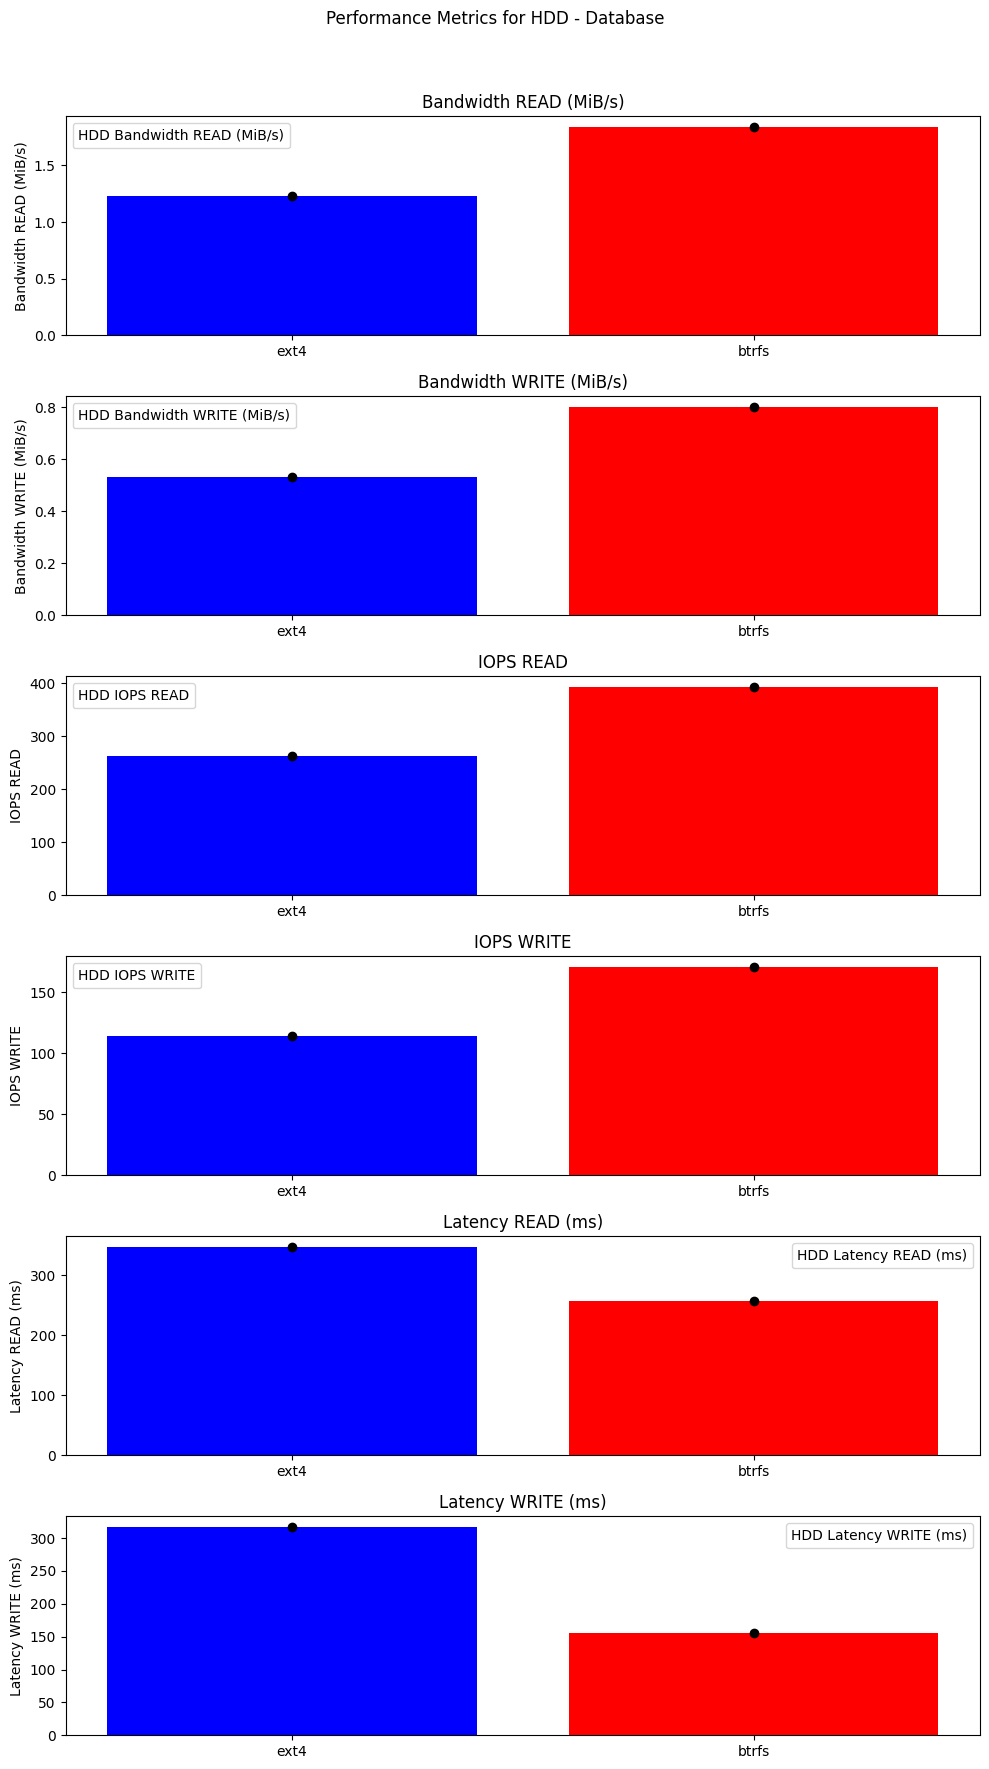

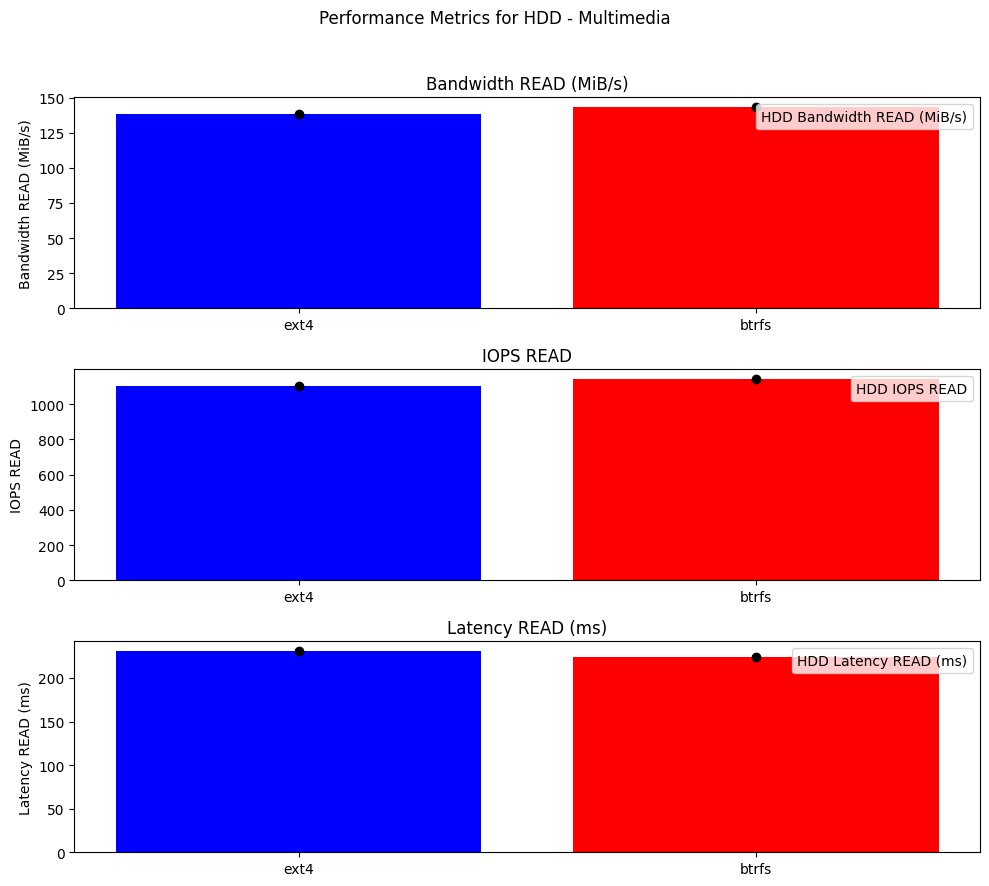

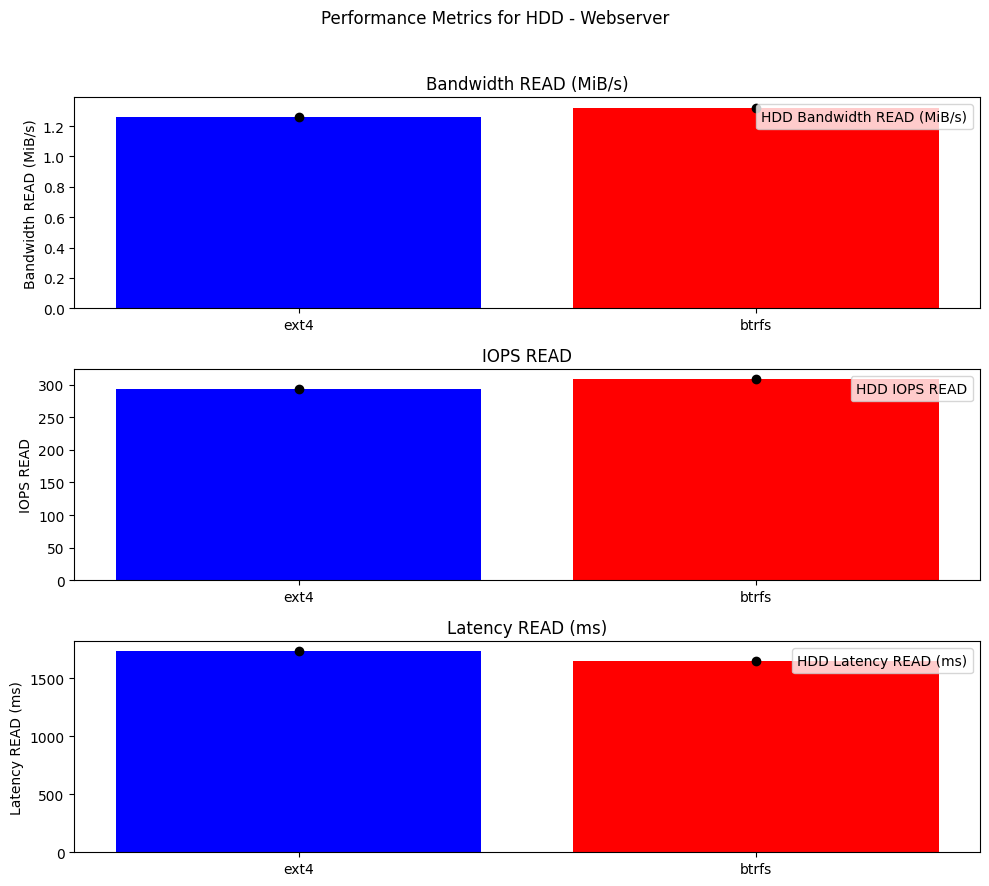

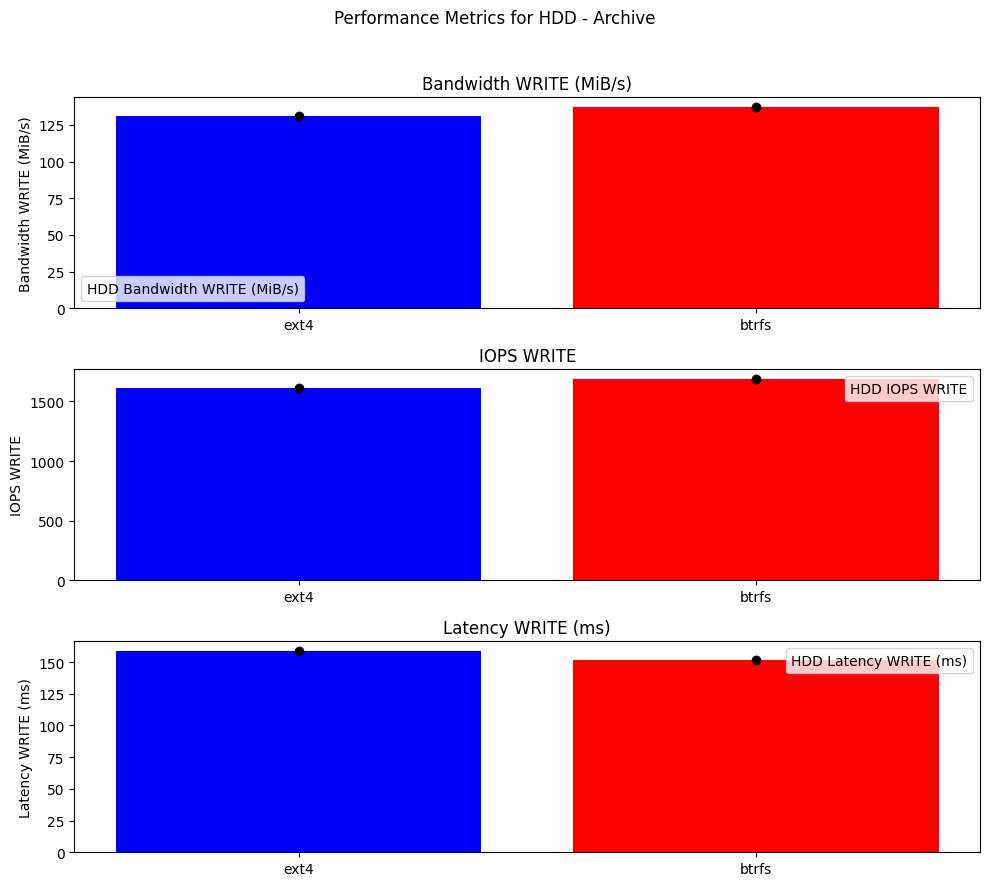

In [48]:

# Example usage
metrics = ["Bandwidth READ (MiB/s)", "Bandwidth WRITE (MiB/s)", "IOPS READ", "IOPS WRITE", "Latency READ (ms)", "Latency WRITE (ms)"]
storage_types = ['HDD', 'SSD', 'NVME']

# Plot performance metrics for fio data
workloads = ["database", "multimedia", "webserver", "archive"]
for workload in workloads:
    plot_performance_metrics(fio_resultsdict, metrics, storage_types, include_min_max=True, workload=workload)


In [49]:
# Function to generate all possible columns
def generate_columns(metrics, stats=["MIN", "MAX", "AVG"], storage_types=["HDD", "SSD", "NVME"], file_systems=None):
    columns = ["File System"]
    for storage in storage_types:
        for metric in metrics:
            for stat in stats:
                columns.append(f"{storage} {metric} {stat}")
    return columns

def extract_row_data(data, columns, file_systems=None):
    rows = []
    for fs, devices in data.items():
        if file_systems and fs not in file_systems:
            continue
        row = [fs]
        for col in columns[1:]:  # Skip File System 
            if len(col.split()) > 3:
                col = col.split()
                storage, metric, stat = col[0], col[1] + ' ' + col[2], col[3]
            else:
                storage, metric, stat = col.split(" ", 2)
            metric_key = f"{metric} (MiB/s)" if "Bandwidth" in metric else metric
            # Extract value
            value = "N/A"
            for device_type, workloads in devices.items():
                if device_type.lower() == storage.lower():
                    for operation, metrics in workloads.items():
                        if metric_key in metrics:
                            value = metrics[metric_key].get(stat.lower(), "N/A")
                            break
            row.append(value)
        rows.append(row)
    return rows

# Example data
# Generate and display tables for dd_resultsdict
print(dd_resultsdict)
columns = generate_columns(["Bandwidth READ", "Bandwidth WRITE"], stats=["MIN", "AVG", "MAX"], storage_types=["HDD", "SSD", "NVME"])
rows = extract_row_data(dd_resultsdict, columns)
df = pd.DataFrame(rows, columns=columns)
display(df.style.set_caption("Performance Metrics: DD Results").format(precision=3))

{'ext4': {'hdd': {'read': {'Bandwidth READ (MiB/s)': {'min': 144.0, 'max': 144.0, 'avg': 144.0}, 'Time (s)': {'min': 7.452, 'max': 7.452, 'avg': 7.45}}, 'write': {'Bandwidth WRITE (MiB/s)': {'min': 154.0, 'max': 154.0, 'avg': 154.0}, 'Time (s)': {'min': 6.952, 'max': 6.952, 'avg': 6.95}}}}, 'xfs': {}, 'btrfs': {'hdd': {'read': {'Bandwidth READ (MiB/s)': {'min': 165.0, 'max': 165.0, 'avg': 165.0}, 'Time (s)': {'min': 6.493, 'max': 6.493, 'avg': 6.49}}, 'write': {'Bandwidth WRITE (MiB/s)': {'min': 166.0, 'max': 166.0, 'avg': 166.0}, 'Time (s)': {'min': 6.457, 'max': 6.457, 'avg': 6.46}}}}, 'zfs': {}, 'f2fs': {}}


,File System,HDD Bandwidth READ MIN,HDD Bandwidth READ AVG,HDD Bandwidth READ MAX,HDD Bandwidth WRITE MIN,HDD Bandwidth WRITE AVG,HDD Bandwidth WRITE MAX,SSD Bandwidth READ MIN,SSD Bandwidth READ AVG,SSD Bandwidth READ MAX,SSD Bandwidth WRITE MIN,SSD Bandwidth WRITE AVG,SSD Bandwidth WRITE MAX,NVME Bandwidth READ MIN,NVME Bandwidth READ AVG,NVME Bandwidth READ MAX,NVME Bandwidth WRITE MIN,NVME Bandwidth WRITE AVG,NVME Bandwidth WRITE MAX
0,ext4,144.000,144.000,144.000,154.000,154.000,154.000,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,xfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
2,btrfs,165.000,165.000,165.000,166.000,166.000,166.000,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,zfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
4,f2fs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


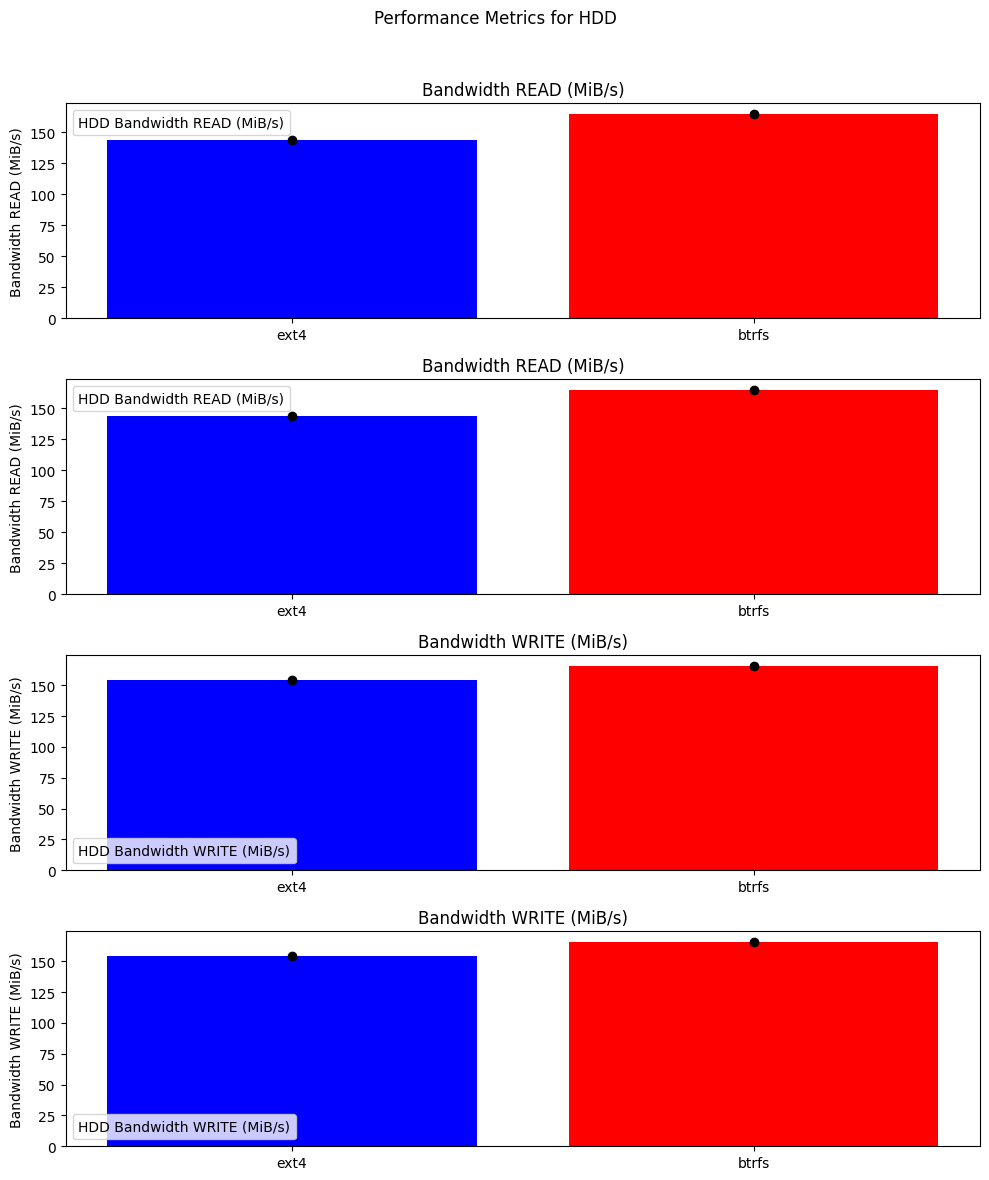

In [50]:

# Plot performance metrics for dd data
plot_performance_metrics(dd_resultsdict, metrics=["Bandwidth READ (MiB/s)", "Bandwidth WRITE (MiB/s)"], storage_types=storage_types, include_min_max=True)

#TODO dodanie uniwersalnej funkcji fo tabelek

In [51]:
import pandas as pd

def generate_columns(metrics, stats=["MIN", "MAX", "AVG"], storage_types=["HDD", "SSD", "NVME"]):
    columns = ["File System"]
    for storage in storage_types:
        for metric in metrics:
            for stat in stats:
                columns.append(f"{storage} {metric} {stat}")
    return columns

def extract_row_data(data, workload, columns, file_systems=None):
    rows = []
    for fs, devices in data.items():
        if file_systems and fs not in file_systems:
            continue
        row = [fs]
        for col in columns[1:]:  # Skip File System 
            if len(col.split()) > 3:
                col = col.split()
                storage, metric, stat = col[0], col[1] + ' ' + col[2], col[3]
            else:
                storage, metric, stat = col.split(" ", 2)
            if workload == 'database':
                if "Latency" in metric:
                    metric_key = f"{metric} (ms)"
                else:
                    metric_key = f"{metric} (MiB/s)" if "Bandwidth" in metric else metric
            elif workload == 'archive':
                if metric == "Latency":
                    metric_key = "Latency WRITE (ms)"
                else:
                    metric_key = f"{metric} WRITE (MiB/s)" if metric == "Bandwidth" else f"{metric} WRITE"
            elif workload == 'dd':
                metric_key = f"{metric} (MiB/s)" if "Bandwidth" in metric else metric
            else:
                if metric == "Latency":
                    metric_key = "Latency READ (ms)"
                else:
                    metric_key = f"{metric} READ (MiB/s)" if metric == "Bandwidth" else f"{metric} READ"
            # Extract value
            value = "N/A"
            for device_type, workloads in devices.items():
                if device_type.lower() == storage.lower() and workload in workloads:
                    if workload == 'dd':
                        for operation, metrics in workloads.items():
                            if metric_key in metrics:
                                value = metrics[metric_key].get(stat.lower(), "N/A")
                                break
                    else:
                        value = workloads[workload].get(metric_key, {}).get(stat.lower(), "N/A")
                    break
            row.append(value)
        rows.append(row)
    return rows

def display_performance_metrics(data, workloads, metrics, stats=["MIN", "AVG", "MAX"], storage_types=["HDD", "SSD", "NVME"], file_systems=None):
    for workload in workloads:
        columns = generate_columns(metrics, stats, storage_types)
        rows = extract_row_data(data, workload, columns, file_systems)
        df = pd.DataFrame(rows, columns=columns)
        display(df.style.set_caption(f"Performance Metrics: {workload.capitalize()}").format(precision=3))

# Example usage
workloads = ["database", "multimedia", "webserver", "archive"]
metrics = {
    "database": ["Bandwidth READ", "Bandwidth WRITE", "IOPS READ", "IOPS WRITE", "Latency READ", "Latency WRITE"],
    "default": ["Bandwidth", "IOPS", "Latency"]
}

# Generate and display tables for each workload
for workload in workloads:
    workload_metrics = metrics.get(workload, metrics["default"])
    display_performance_metrics(fio_resultsdict, [workload], workload_metrics)

# For dd data
dd_metrics = ["Bandwidth READ", "Bandwidth WRITE"]
display_performance_metrics(dd_resultsdict, ["dd"], dd_metrics)

,File System,HDD Bandwidth READ MIN,HDD Bandwidth READ AVG,HDD Bandwidth READ MAX,HDD Bandwidth WRITE MIN,HDD Bandwidth WRITE AVG,HDD Bandwidth WRITE MAX,HDD IOPS READ MIN,HDD IOPS READ AVG,HDD IOPS READ MAX,HDD IOPS WRITE MIN,HDD IOPS WRITE AVG,HDD IOPS WRITE MAX,HDD Latency READ MIN,HDD Latency READ AVG,HDD Latency READ MAX,HDD Latency WRITE MIN,HDD Latency WRITE AVG,HDD Latency WRITE MAX,SSD Bandwidth READ MIN,SSD Bandwidth READ AVG,SSD Bandwidth READ MAX,SSD Bandwidth WRITE MIN,SSD Bandwidth WRITE AVG,SSD Bandwidth WRITE MAX,SSD IOPS READ MIN,SSD IOPS READ AVG,SSD IOPS READ MAX,SSD IOPS WRITE MIN,SSD IOPS WRITE AVG,SSD IOPS WRITE MAX,SSD Latency READ MIN,SSD Latency READ AVG,SSD Latency READ MAX,SSD Latency WRITE MIN,SSD Latency WRITE AVG,SSD Latency WRITE MAX,NVME Bandwidth READ MIN,NVME Bandwidth READ AVG,NVME Bandwidth READ MAX,NVME Bandwidth WRITE MIN,NVME Bandwidth WRITE AVG,NVME Bandwidth WRITE MAX,NVME IOPS READ MIN,NVME IOPS READ AVG,NVME IOPS READ MAX,NVME IOPS WRITE MIN,NVME IOPS WRITE AVG,NVME IOPS WRITE MAX,NVME Latency READ MIN,NVME Latency READ AVG,NVME Latency READ MAX,NVME Latency WRITE MIN,NVME Latency WRITE AVG,NVME Latency WRITE MAX
0,ext4,1.233,1.230,1.233,0.534,0.530,0.534,262.000,262.000,262.000,114.000,114.000,114.000,347.680,347.680,347.680,317.196,317.200,317.196,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,xfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
2,btrfs,1.842,1.840,1.842,0.802,0.800,0.802,393.000,393.000,393.000,171.000,171.000,171.000,256.800,256.800,256.800,155.970,155.970,155.970,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,zfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
4,f2fs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


,File System,HDD Bandwidth MIN,HDD Bandwidth AVG,HDD Bandwidth MAX,HDD IOPS MIN,HDD IOPS AVG,HDD IOPS MAX,HDD Latency MIN,HDD Latency AVG,HDD Latency MAX,SSD Bandwidth MIN,SSD Bandwidth AVG,SSD Bandwidth MAX,SSD IOPS MIN,SSD IOPS AVG,SSD IOPS MAX,SSD Latency MIN,SSD Latency AVG,SSD Latency MAX,NVME Bandwidth MIN,NVME Bandwidth AVG,NVME Bandwidth MAX,NVME IOPS MIN,NVME IOPS AVG,NVME IOPS MAX,NVME Latency MIN,NVME Latency AVG,NVME Latency MAX
0,ext4,138.000,138.000,138.000,1105.000,1105.000,1105.000,230.480,230.480,230.480,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,xfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
2,btrfs,143.000,143.000,143.000,1140.000,1140.000,1140.000,223.590,223.590,223.590,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,zfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
4,f2fs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


,File System,HDD Bandwidth MIN,HDD Bandwidth AVG,HDD Bandwidth MAX,HDD IOPS MIN,HDD IOPS AVG,HDD IOPS MAX,HDD Latency MIN,HDD Latency AVG,HDD Latency MAX,SSD Bandwidth MIN,SSD Bandwidth AVG,SSD Bandwidth MAX,SSD IOPS MIN,SSD IOPS AVG,SSD IOPS MAX,SSD Latency MIN,SSD Latency AVG,SSD Latency MAX,NVME Bandwidth MIN,NVME Bandwidth AVG,NVME Bandwidth MAX,NVME IOPS MIN,NVME IOPS AVG,NVME IOPS MAX,NVME Latency MIN,NVME Latency AVG,NVME Latency MAX
0,ext4,1.258,1.260,1.258,293.000,293.000,293.000,1733.880,1733.880,1733.880,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,xfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
2,btrfs,1.323,1.320,1.323,308.000,308.000,308.000,1650.730,1650.730,1650.730,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,zfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
4,f2fs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


,File System,HDD Bandwidth MIN,HDD Bandwidth AVG,HDD Bandwidth MAX,HDD IOPS MIN,HDD IOPS AVG,HDD IOPS MAX,HDD Latency MIN,HDD Latency AVG,HDD Latency MAX,SSD Bandwidth MIN,SSD Bandwidth AVG,SSD Bandwidth MAX,SSD IOPS MIN,SSD IOPS AVG,SSD IOPS MAX,SSD Latency MIN,SSD Latency AVG,SSD Latency MAX,NVME Bandwidth MIN,NVME Bandwidth AVG,NVME Bandwidth MAX,NVME IOPS MIN,NVME IOPS AVG,NVME IOPS MAX,NVME Latency MIN,NVME Latency AVG,NVME Latency MAX
0,ext4,131.000,131.000,131.000,1612.000,1612.000,1612.000,158.393,158.390,158.393,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,xfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
2,btrfs,137.000,137.000,137.000,1685.000,1685.000,1685.000,151.830,151.830,151.830,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,zfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
4,f2fs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


,File System,HDD Bandwidth READ MIN,HDD Bandwidth READ AVG,HDD Bandwidth READ MAX,HDD Bandwidth WRITE MIN,HDD Bandwidth WRITE AVG,HDD Bandwidth WRITE MAX,SSD Bandwidth READ MIN,SSD Bandwidth READ AVG,SSD Bandwidth READ MAX,SSD Bandwidth WRITE MIN,SSD Bandwidth WRITE AVG,SSD Bandwidth WRITE MAX,NVME Bandwidth READ MIN,NVME Bandwidth READ AVG,NVME Bandwidth READ MAX,NVME Bandwidth WRITE MIN,NVME Bandwidth WRITE AVG,NVME Bandwidth WRITE MAX
0,ext4,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,xfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
2,btrfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,zfs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
4,f2fs,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
